In [1]:
import math
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import os
import matplotlib.pyplot as plt
from torch.utils import data
from tqdm import tqdm

In [2]:
sz=224
batch_size=16

In [3]:
# Load the Drive helper and mount
from google.colab import drive


In [4]:
path="/content/drive/MyDrive/dev/"

In [5]:
os.listdir("/content/drive/MyDrive/dev/")

['train', 'valid']

In [6]:
train_dir=f"{path}train"

In [7]:
valid_dir=f"{path}valid"

In [58]:
#data augmentaion
train_transforms=transforms.Compose([
    transforms.Resize((sz , sz)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.1 , 0.1 , 0.1 , 0.1 ),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5] , [0.229,0.224,0.225])]
)

valid_transforms=transforms.Compose([
    transforms.Resize((sz ,sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5] , [0.229,0.224,0.225])
    
])

In [59]:
train_ds=datasets.ImageFolder(train_dir, transform=train_transforms)


In [60]:
valid_ds=datasets.ImageFolder(valid_dir, transform=valid_transforms)

In [34]:
len(train_ds.imgs)

2010

In [35]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [36]:
train_ds.imgs[:10]

[('/content/drive/MyDrive/dev/train/cat/0.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/1.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/10.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/100.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/101.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/102.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/103.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/104.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/105.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/106.jpg', 0)]

In [37]:
trn_fnames=glob.glob(f"{train_dir}/*/*.jpg")
                     
trn_fnames[:5]       

['/content/drive/MyDrive/dev/train/dog/100.jpg',
 '/content/drive/MyDrive/dev/train/dog/10.jpg',
 '/content/drive/MyDrive/dev/train/dog/0.jpg',
 '/content/drive/MyDrive/dev/train/dog/1.jpg',
 '/content/drive/MyDrive/dev/train/dog/101.jpg']

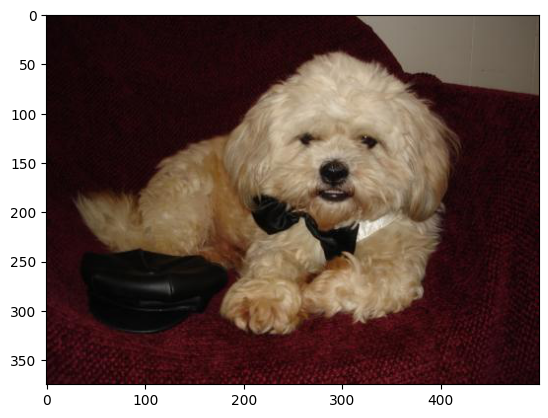

In [38]:
img=plt.imread(trn_fnames[52])
plt.imshow(img)  

In [39]:
#dataloaders
train_dl=data.DataLoader(train_ds , batch_size= batch_size , shuffle= True )

In [61]:


valid_dl =data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [41]:
inputs , targets=next(iter(train_dl))




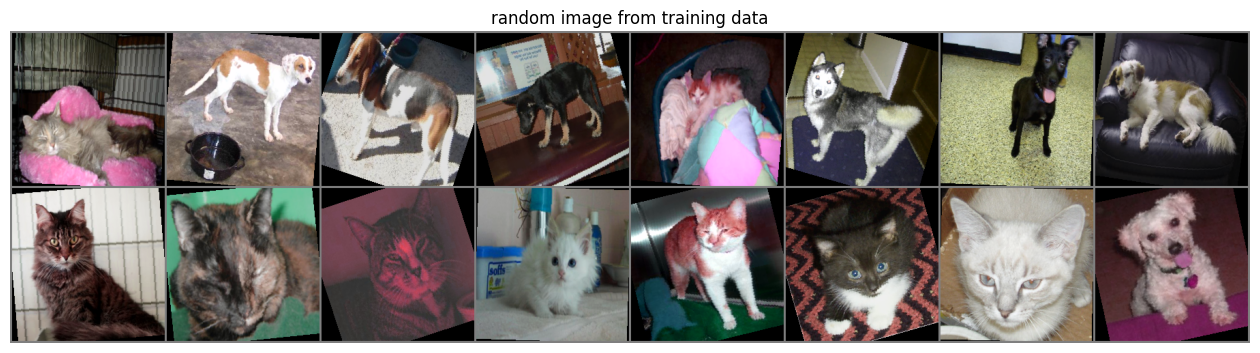

In [42]:
out=torchvision.utils.make_grid(inputs , padding=3)
title="random image from training data"
inp = out.numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std  = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.figure(figsize=(16,12))
plt.imshow(inp)
plt.axis('off')
if title is not None:
        plt.title(title)

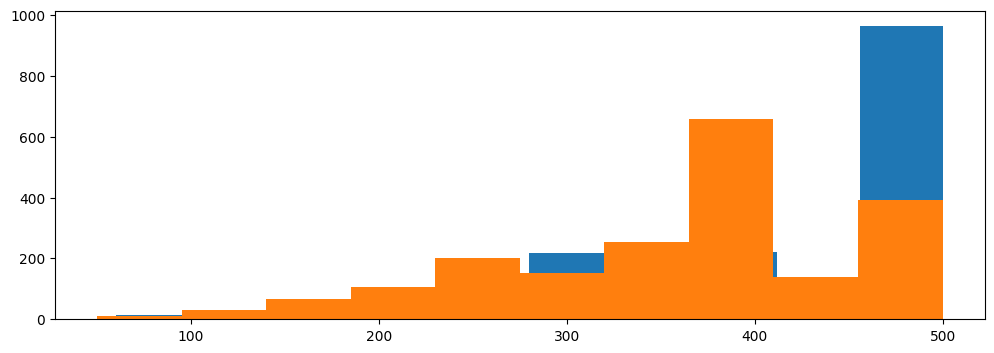

In [48]:
#Look at the sizes of the images
fnames = glob.glob(f'{train_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [62]:
from torch.nn.modules.batchnorm import BatchNorm2d
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN , self).__init__()
    self.conv1= nn.Sequential(
        nn.Conv2d(3,16 , kernel_size= 5 , padding=2),  #3:dimension , 16 kernels
        nn.BatchNorm2d(16),
        nn.ReLU() )

    self.conv2= nn.Sequential(
        nn.Conv2d(16, 32, kernel_size= 5 , padding="same"),
        nn.BatchNorm2d(32),
        nn.ReLU() )
    
    self.conv3=nn.Sequential(
        nn.Conv2d(32,64 , kernel_size= 5 , padding="same"),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv4= nn.Sequential(
        nn.Conv2d(64,112, kernel_size=5, padding="same"),
        nn.BatchNorm2d(112),
        nn.ReLU()  )
    
    self.conv5= nn.Sequential(
        nn.Conv2d(112, 224, kernel_size=5 , padding="same"),
        nn.BatchNorm2d(224),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv6=nn.Sequential(
        nn.Conv2d(224 , 512 , kernel_size = 5 , padding="same"),
        nn.BatchNorm2d(512),
        nn.ReLU())
    
    self.conv7=nn.Sequential(
        nn.Conv2d(512 , 720 , kernel_size=5 , padding= "same"),
        nn.BatchNorm2d(720),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.dense=nn.Linear(28*28*720, 2)
    
  def forward (self , X):
    out=self.conv1(X)
    out=self.conv2(out)
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.conv5(out)
    out=self.conv6(out)
    out=self.conv7(out)
    out=out.view(out.size(0), -1)
    out=self.dense(out)
    return out


    


In [63]:
model=SimpleCNN()
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)


In [80]:
#loss_function
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters() , lr= 0.004 , momentum= 0.9 )

In [81]:
#train
num_epochs=5
losess=[]
for epoch in range(num_epochs):
  for i , (inputs, targets) in enumerate(train_dl):
    inputs=inputs.to(device)
    targets=targets.to(device)
    #forward pass
    outputs=model(inputs)

    #loss
    loss=criterion(outputs , targets)
    losess.append(loss.item())

    #backwards
    optimizer.zero_grad()
    loss.backward()

    #update parameters
    optimizer.step()

    #report
    if(i+1)%50==0:
      print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))
      



Epoch [ 1/ 5], Step [ 50/125], Loss: 0.6300
Epoch [ 1/ 5], Step [100/125], Loss: 0.7232
Epoch [ 2/ 5], Step [ 50/125], Loss: 0.7316
Epoch [ 2/ 5], Step [100/125], Loss: 0.7056
Epoch [ 3/ 5], Step [ 50/125], Loss: 0.6436
Epoch [ 3/ 5], Step [100/125], Loss: 0.6736
Epoch [ 4/ 5], Step [ 50/125], Loss: 0.6145
Epoch [ 4/ 5], Step [100/125], Loss: 0.6392
Epoch [ 5/ 5], Step [ 50/125], Loss: 0.4723
Epoch [ 5/ 5], Step [100/125], Loss: 0.5645


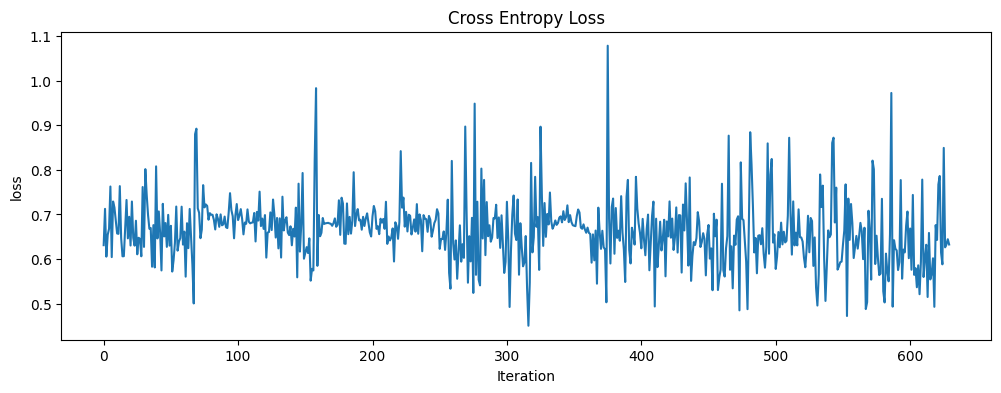

In [84]:
plt.figure(figsize=(12, 4))
plt.plot(losess)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [85]:
def evaluate_model(model, dataloader, device):
    model.eval()               # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [86]:
evaluate_model(model, valid_dl, device)

accuracy: 62.19


In [87]:
evaluate_model(model, train_dl, device)

accuracy: 69.25


In [67]:
def visualize_model(model, dataloader, device, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [68]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

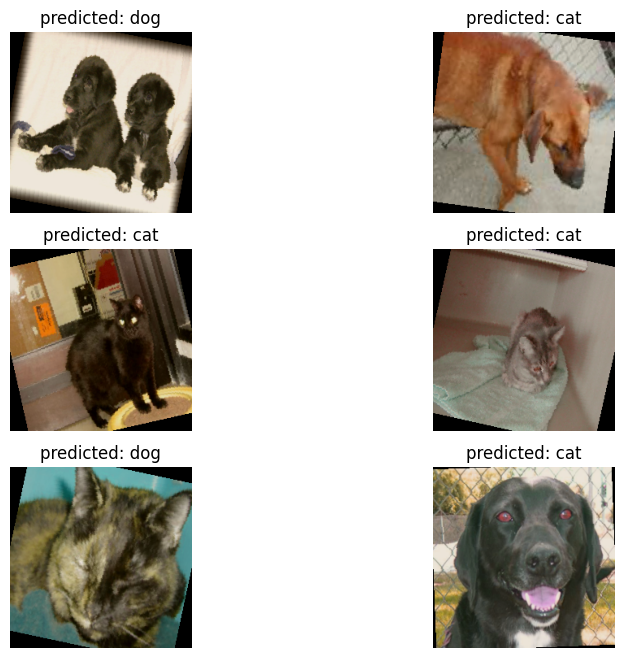

In [69]:
visualize_model(model, train_dl, device)

In [70]:
def plot_errors(model, dataloader, device):
    model.eval()
    plt.figure(figsize=(12, 24))
    count = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.cpu().numpy())

            for idx in incorrect_idxs:
                count += 1
                if count > 30: break
                ax = plt.subplot(10, 3, count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
                imshow(inputs.cpu().data[idx])
    
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))

100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


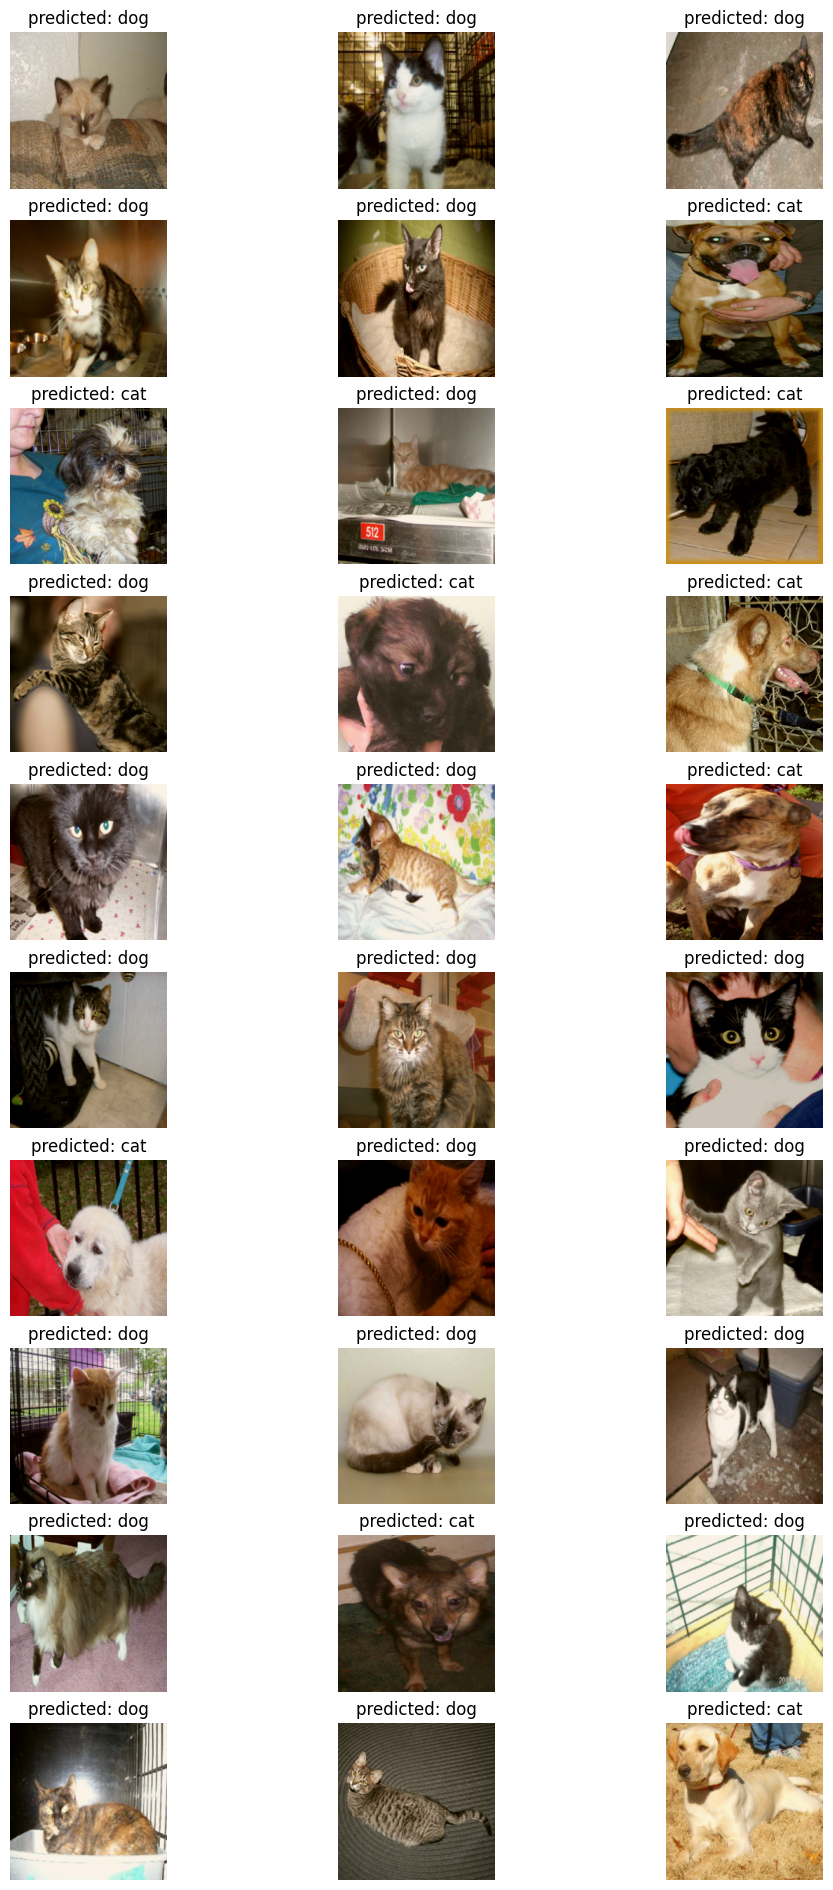

39 images out of 201 were misclassified.


In [82]:
plot_errors(model, valid_dl, device)

In [88]:
from torchvision.models import resnet50

In [89]:
# load pre-trained ResNet18
#model = load_pretrained_resnet50(model_path= None, num_classes=2)
model = models.resnet50(pretrained=True).to(device)
#model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 256MB/s]


In [90]:
#train
num_epochs=5
losess=[]
for epoch in range(num_epochs):
  for i , (inputs, targets) in enumerate(train_dl):
    inputs=inputs.to(device)
    targets=targets.to(device)
    #forward pass
    outputs=model(inputs)

    #loss
    loss=criterion(outputs , targets)
    losess.append(loss.item())

    #backwards
    optimizer.zero_grad()
    loss.backward()

    #update parameters
    optimizer.step()

    #report
    if(i+1)%50==0:
      print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/ 5], Step [ 50/125], Loss: 1.6710
Epoch [ 1/ 5], Step [100/125], Loss: 0.0065
Epoch [ 2/ 5], Step [ 50/125], Loss: 0.0271
Epoch [ 2/ 5], Step [100/125], Loss: 0.0220
Epoch [ 3/ 5], Step [ 50/125], Loss: 0.0037
Epoch [ 3/ 5], Step [100/125], Loss: 0.2596
Epoch [ 4/ 5], Step [ 50/125], Loss: 0.0066
Epoch [ 4/ 5], Step [100/125], Loss: 0.0003
Epoch [ 5/ 5], Step [ 50/125], Loss: 0.0310
Epoch [ 5/ 5], Step [100/125], Loss: 0.0010


In [91]:
def evaluate_model(model, dataloader, device):
    model.eval()               # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [92]:
evaluate_model(model, valid_dl, device)

accuracy: 97.01


In [93]:
evaluate_model(model, train_dl, device)

accuracy: 99.60
